# Import

In [1]:
import os, sys
import joblib
import importlib

import pandas as pd
import polars as pl
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import dproc, sgml, sgutil, sgpp

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

print(sys.version)
for i in [pd, pl, mpl, sns, np, lgb, cb, xgb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
lightgbm 4.3.0
catboost 1.2.5
xgboost 2.1.2


In [2]:
from datetime import date


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from scipy.stats import chi2_contingency, pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 

# Load Data

In [3]:
data_path = 'data'
files = {
    'train': os.path.join(data_path, 'train.csv'),
    'test': os.path.join(data_path, 'test.csv'),
    'vars': os.path.join(data_path, 'vars.pkl')
}
for i in ['result', 'data', 'model', 'img']:
    if not os.path.isdir(i):
        os.mkdir(i)

sc = sgutil.SGCache('img', 'result')

In [4]:
if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['vars'])):
    !kaggle competitions download -c playground-series-s5e1
    if not os.path.exists(data_path):
        !mkdir data
    !unzip playground-series-s5e1.zip -d data
    !rm playground-series-s5e1.zip

In [92]:
min_dt = date(year = 2010, month = 1, day = 1)
t = sc.cache_result(
    'pl_pipeline',
    lambda : make_pipeline(
        sgpp.PolarsProcessor({'date': pl.Datetime}), 
        sgpp.ExprProcessor({
            'year':  pl.col('date').dt.year(),
            'month':  pl.col('date').dt.month(),
            'day':  pl.col('date').dt.day(),
            'weekday':  pl.col('date').dt.weekday(),
            'days': (pl.col('date') - min_dt).dt.total_days().cast(pl.Int16),
            'y_8': ((pl.col('date').dt.year() - 2007) % 8).cast(pl.Int8),
            'y_2': (pl.col('date').dt.year() % 2).cast(pl.Int8),
            'md': pl.col('date').dt.strftime('%m-%d').cast(pl.Categorical)
        }),
        sgpp.PandasCoverter(index_col = 'id')
    ).fit(files['train']), rerun = 1
)
df_train = t.transform(files['train'])
df_test = t.transform(files['test'])

In [93]:
df_train.isna().agg(['sum', 'mean'])

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md
sum,0.0,0.0,0.0,0.0,8871.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.038548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
df_test.isna().agg(['sum', 'mean'])

,date,country,store,product,year,month,day,weekday,days,y_8,y_2,md
sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
target = 'num_sold'
X_nom = ['country', 'store', 'product', 'weekday', 'month', 'md', 'y_8', 'y_2']
X_cat = X_nom
X_num = ['days', 'day']

In [98]:
df_train['date'].agg(['min', 'max']), df_test['date'].agg(['min', 'max'])

(min   2010-01-01
 max   2016-12-31
 Name: date, dtype: datetime64[ns],
 min   2017-01-01
 max   2019-12-31
 Name: date, dtype: datetime64[ns])

# Target

In [99]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
num_sold,221259.0,752.527405,690.165466,5.0,219.0,605.0,1114.0,5939.0


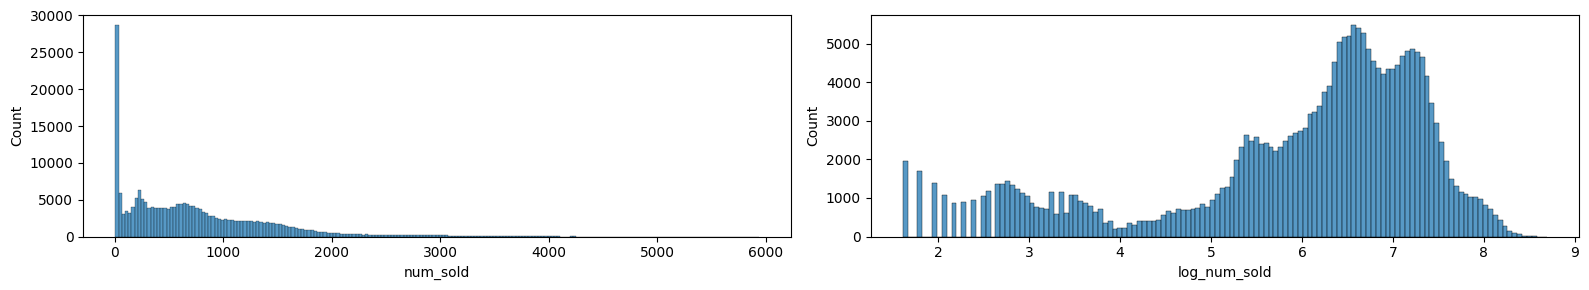

In [100]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(
    df_train[target] , ax = axes[0]
)

sns.histplot(
    np.log(df_train[target]).rename('log_num_sold') , ax = axes[1]
)
plt.tight_layout()
plt.show()

In [101]:
df_train['date'].value_counts().unique()

array([90])

In [102]:
df_train.groupby('date')[target].agg(lambda x: x.isna().sum()).rename('na_cnt_by_date').value_counts().rename('count of na_cnt_by_date').to_frame().T

na_cnt_by_date,3,2,4,5,6,7
count of na_cnt_by_date,748,679,534,447,145,4


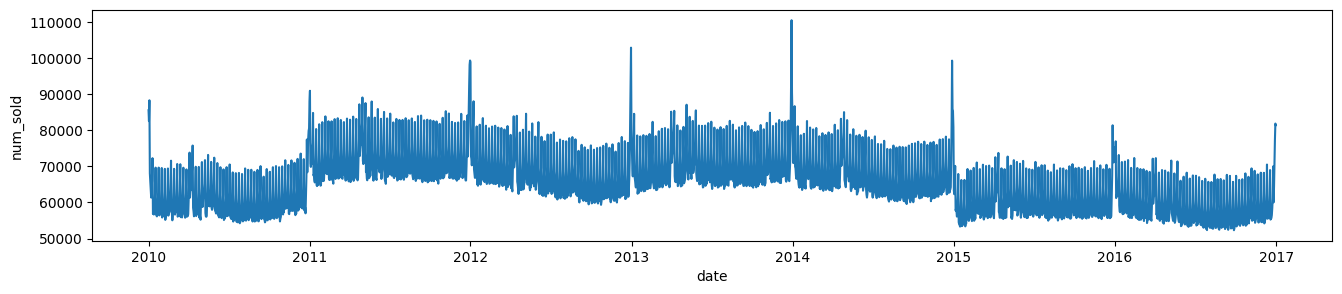

In [103]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby('date')[target].agg(lambda x: x.sort_values(ascending = False).iloc[:-6].sum())
)
plt.show()

# Categorical Variables

In [104]:
df_train[X_cat].apply(lambda x: x.nunique()).rename('nunique').to_frame().T

,country,store,product,weekday,month,md,y_8,y_2
nunique,6,3,5,7,12,366,7,2


In [105]:
for i in X_cat:
    display(df_train[i].value_counts().to_frame().T)

country,Canada,Finland,Italy,Kenya,Norway,Singapore
count,38355,38355,38355,38355,38355,38355


store,Discount Stickers,Stickers for Less,Premium Sticker Mart
count,76710,76710,76710


product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
count,46026,46026,46026,46026,46026


weekday,5,6,7,1,2,3,4
count,32940,32940,32850,32850,32850,32850,32850


month,1,3,5,7,8,10,12,4,6,9,11,2
count,19530,19530,19530,19530,19530,19530,19530,18900,18900,18900,18900,17820


md,01-01,09-09,09-07,09-06,09-05,09-04,09-03,09-02,09-01,08-31,...,04-27,05-05,05-04,05-03,05-02,05-01,04-30,04-29,04-28,02-29
count,630,630,630,630,630,630,630,630,630,630,...,630,630,630,630,630,630,630,630,630,180


y_8,5,1,3,4,6,7,0
count,32940,32940,32850,32850,32850,32850,32850


y_2,0,1
count,131580,98550


# Imputing NA in num_sold

In [106]:
df_train[X_cat].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target].isna())).pvalue
)

country    0.000000e+00
store      0.000000e+00
product    0.000000e+00
weekday    8.483659e-44
month      6.909299e-79
md         3.966093e-04
y_8        1.690005e-51
y_2        2.092241e-01
dtype: float64

In [107]:
pd.crosstab(index = df_train['country'], columns = df_train[target].isna()).T

country,Canada,Finland,Italy,Kenya,Norway,Singapore
num_sold,,,,,,
False,34109,38355,38355,33730,38355,38355
True,4246,0,0,4625,0,0


In [108]:
pd.crosstab(index = df_train['product'], columns = df_train[target].isna()).T

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
num_sold,,,,,
False,37220,46026,46026,45962,46025
True,8806,0,0,64,1


In [109]:
pd.crosstab(index = df_train['store'], columns = df_train[target].isna()).T

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
num_sold,,,
False,71531,74044,75684
True,5179,2666,1026


In [110]:
df_train.loc[(df_train['country'] == 'Canada') & (df_train[target].isna()), ['store', 'product']].value_counts()

store                 product          
Discount Stickers     Holographic Goose    2557
Stickers for Less     Holographic Goose    1308
Premium Sticker Mart  Holographic Goose     380
Discount Stickers     Kerneler                1
Name: count, dtype: int64

In [111]:
df_train.loc[(df_train['country'] == 'Kenya') & (df_train[target].isna()), ['store', 'product']].value_counts()

store                 product           
Discount Stickers     Holographic Goose     2557
Stickers for Less     Holographic Goose     1358
Premium Sticker Mart  Holographic Goose      646
Discount Stickers     Kerneler                63
                      Kerneler Dark Mode       1
Name: count, dtype: int64

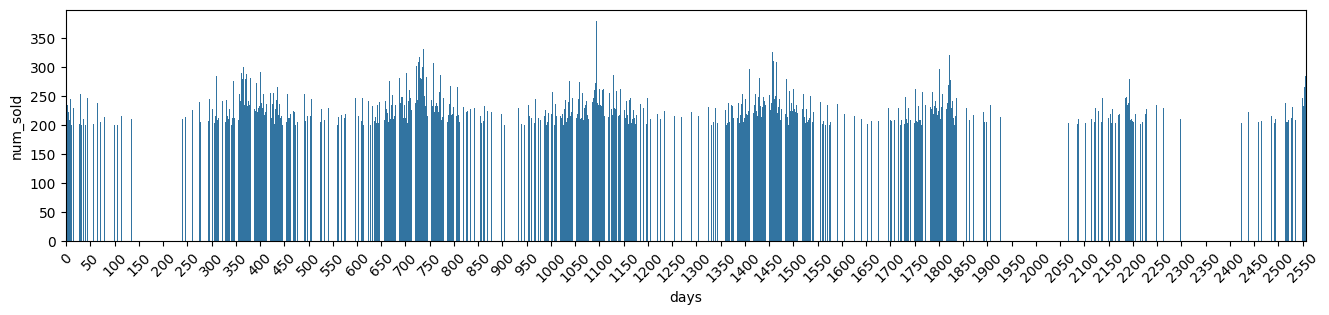

In [112]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Canada'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Stickers for Less")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

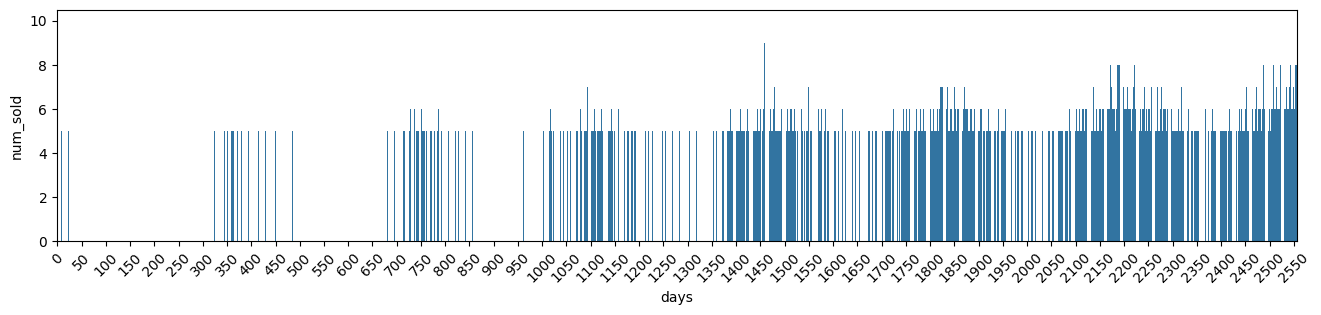

In [113]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Kenya'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Stickers for Less")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

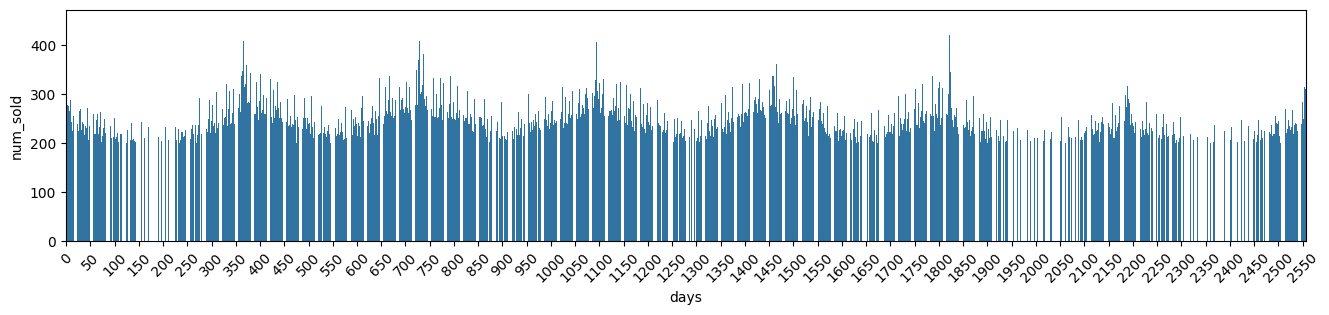

In [114]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Canada'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Premium Sticker Mart")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

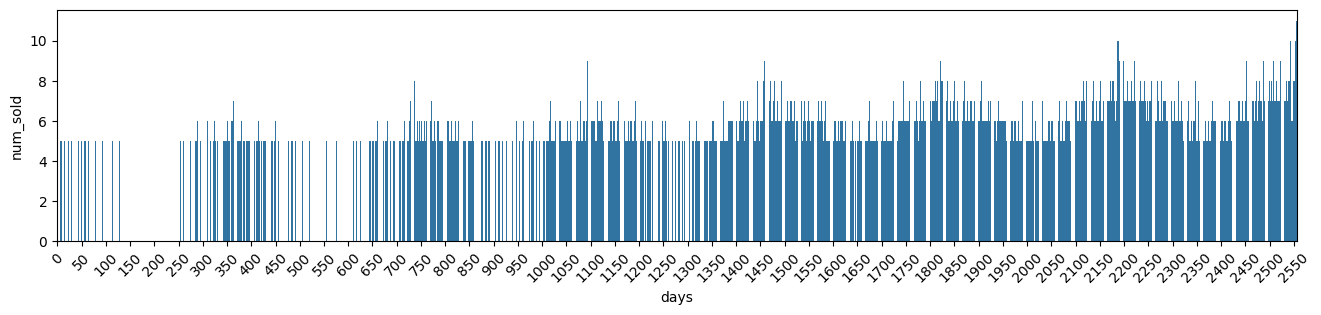

In [115]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Kenya'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Premium Sticker Mart")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

In [116]:
df_train.loc[(df_train['product'] == 'Kerneler Dark Mode') & df_train[target].isna()]

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md
id,,,,,,,,,,,,,
23719,2010-09-21,Kenya,Discount Stickers,Kerneler Dark Mode,NaN,2010,9,21,2,263,3,0,09-21


In [117]:
df_train.loc[(df_train['product'] == 'Kerneler Dark Mode') & (df_train['country'] == 'Kenya') & df_train['days'].isin([262, 264])]

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md
id,,,,,,,,,,,,,
23629,2010-09-20,Kenya,Discount Stickers,Kerneler Dark Mode,5.0,2010,9,20,1,262,3,0,09-20
23634,2010-09-20,Kenya,Stickers for Less,Kerneler Dark Mode,10.0,2010,9,20,1,262,3,0,09-20
23639,2010-09-20,Kenya,Premium Sticker Mart,Kerneler Dark Mode,13.0,2010,9,20,1,262,3,0,09-20
23809,2010-09-22,Kenya,Discount Stickers,Kerneler Dark Mode,5.0,2010,9,22,3,264,3,0,09-22
23814,2010-09-22,Kenya,Stickers for Less,Kerneler Dark Mode,11.0,2010,9,22,3,264,3,0,09-22
23819,2010-09-22,Kenya,Premium Sticker Mart,Kerneler Dark Mode,13.0,2010,9,22,3,264,3,0,09-22


In [118]:
df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target] = df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target].fillna(5)
df_train.loc[(df_train['product'] == 'Kerneler'), target] = \
    df_train.loc[(df_train['product'] == 'Kerneler')].groupby(['country', 'store'], observed = False)[target].transform(
        lambda x: x.interpolate()
    )

In [119]:
df_train.groupby('date')[target].agg(lambda x: x.isna().sum()).rename('na_cnt_by_date').value_counts().rename('count of na_cnt_by_date').to_frame().T

na_cnt_by_date,3,2,4,5,6
count of na_cnt_by_date,751,679,547,473,107


In [120]:
df_train.loc[df_train['product'] != 'Holographic Goose', target].isna().sum()

0

In [121]:
df_train.loc[~df_train['country'].isin(['Canada', 'Kenya']), target].isna().sum()

0

In [122]:
df_ratio_product = df_train.loc[~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['product'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_product.head()

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
days,,,,,
0,0.052199,0.329210,0.289181,0.154402,0.175008
1,0.051393,0.331010,0.290622,0.148871,0.178105
2,0.051953,0.332878,0.289431,0.150612,0.175125
3,0.052749,0.325723,0.297911,0.146376,0.177240
4,0.051869,0.329591,0.290967,0.147771,0.179801


In [123]:
df_ratio_country = df_train.loc[df_train['product'] != 'Holographic Goose'].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['country'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_country.head()

country,Canada,Finland,Italy,Kenya,Norway,Singapore
days,,,,,,
0,0.177600,0.178992,0.135909,0.003460,0.325773,0.178265
1,0.181301,0.173870,0.131336,0.003505,0.328672,0.181314
2,0.178494,0.175288,0.135738,0.003468,0.328460,0.178553
3,0.175085,0.174729,0.133957,0.003514,0.334303,0.178413
4,0.175983,0.177955,0.139273,0.003543,0.326975,0.176272


In [124]:
df_ratio_store = df_train.loc[(df_train['product'] != 'Holographic Goose') & ~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['store'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_store.head()

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
days,,,
0,0.182737,0.373427,0.443836
1,0.185237,0.373569,0.441194
2,0.185028,0.359058,0.455913
3,0.182531,0.375596,0.441873
4,0.185612,0.380036,0.434352


In [125]:
df_ratio = pd.DataFrame(
    0,
    columns = pd.MultiIndex.from_product(df_train[X_cat[:3]].apply(lambda x: x.unique().tolist())),
    index = df_train['days'].unique()
).apply(
    lambda x: df_ratio_country.loc[:, x.name[0]] * df_ratio_store.loc[:, x.name[1]] * df_ratio_product.loc[:, x.name[2]]
)
df_ratio.head()

Canada                                                      \
     Discount Stickers                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.001694  0.010684     0.009385  0.005011           0.005680   
1             0.001726  0.011117     0.009760  0.005000           0.005981   
2             0.001716  0.010994     0.009559  0.004974           0.005784   
3             0.001686  0.010410     0.009521  0.004678           0.005664   
4             0.001694  0.010766     0.009504  0.004827           0.005873   

                                                                            \
     Stickers for Less                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.003462  0.021833     0.019179  0.010240           0.011607   
1             0.003481  0.022419     0.019683  0.010083           0.012063   
2             0.003330  0.021334     0.018550  0.009653           0.011224   
3             0.003469  0.021420     0.019591  0.009626           0.011656   
4             0.003469  0.022043     0.019460  0.009883           0.012025   

      ...         Singapore                                   \
      ... Stickers for Less                                    
      ... Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days  ...                                                      
0     ...          0.003475  0.021915     0.019251  0.010278   
1     ...          0.003481  0.022420     0.019685  0.010084   
2     ...          0.003331  0.021341     0.018556  0.009656   
3     ...          0.003535  0.021827     0.019963  0.009809   
4     ...          0.003475  0.022079     0.019492  0.009899   

                                                                               \
                        Premium Sticker Mart                                    
     Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days                                                                            
0              0.011650             0.004130  0.026047     0.022880  0.012216   
1              0.012064             0.004111  0.026479     0.023248  0.011909   
2              0.011227             0.004229  0.027098     0.023561  0.012261   
3              0.011877             0.004159  0.025679     0.023486  0.011540   
4              0.012045             0.003971  0.025235     0.022278  0.011314   

                         
                         
     Kerneler Dark Mode  
days                     
0              0.013847  
1              0.014247  
2              0.014256  
3              0.013973  
4              0.013766  

[5 rows x 90 columns]

In [126]:
df_ratio_notna = pd.DataFrame(
    df_ratio.values * df_train.assign(target_notna = lambda x: x[target].notna()).pivot(
        index = 'days', columns = X_cat[:3], values = 'target_notna'
    ).values, index = df_ratio.index, columns = df_ratio.columns
)
df_ratio_notna.head()

Canada                                                      \
     Discount Stickers                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0                  0.0  0.010684     0.009385  0.005011           0.005680   
1                  0.0  0.011117     0.009760  0.005000           0.005981   
2                  0.0  0.010994     0.009559  0.004974           0.005784   
3                  0.0  0.010410     0.009521  0.004678           0.005664   
4                  0.0  0.010766     0.009504  0.004827           0.005873   

                                                                            \
     Stickers for Less                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.003462  0.021833     0.019179  0.010240           0.011607   
1             0.003481  0.022419     0.019683  0.010083           0.012063   
2             0.003330  0.021334     0.018550  0.009653           0.011224   
3             0.003469  0.021420     0.019591  0.009626           0.011656   
4             0.003469  0.022043     0.019460  0.009883           0.012025   

      ...         Singapore                                   \
      ... Stickers for Less                                    
      ... Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days  ...                                                      
0     ...          0.003475  0.021915     0.019251  0.010278   
1     ...          0.003481  0.022420     0.019685  0.010084   
2     ...          0.003331  0.021341     0.018556  0.009656   
3     ...          0.003535  0.021827     0.019963  0.009809   
4     ...          0.003475  0.022079     0.019492  0.009899   

                                                                               \
                        Premium Sticker Mart                                    
     Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days                                                                            
0              0.011650             0.004130  0.026047     0.022880  0.012216   
1              0.012064             0.004111  0.026479     0.023248  0.011909   
2              0.011227             0.004229  0.027098     0.023561  0.012261   
3              0.011877             0.004159  0.025679     0.023486  0.011540   
4              0.012045             0.003971  0.025235     0.022278  0.011314   

                         
                         
     Kerneler Dark Mode  
days                     
0              0.013847  
1              0.014247  
2              0.014256  
3              0.013973  
4              0.013766  

[5 rows x 90 columns]

In [127]:
s_est_daily_sum = df_train.groupby('days')[target].sum() * 1 / df_ratio_notna.sum(axis = 1)
s_est_daily_sum.head()

days
0    85714.031250
1    82693.492188
2    88482.773438
3    68197.023438
4    65831.382812
dtype: float32

In [128]:
df_train.loc[df_train[target].isna(), target] = df_train.loc[df_train[target].isna()].apply(
    lambda x: df_ratio.loc[x['days'], tuple(x[X_cat[:3]])] * s_est_daily_sum.loc[x['days']], axis = 1
)

In [129]:
df_train[target].isna().sum()

0

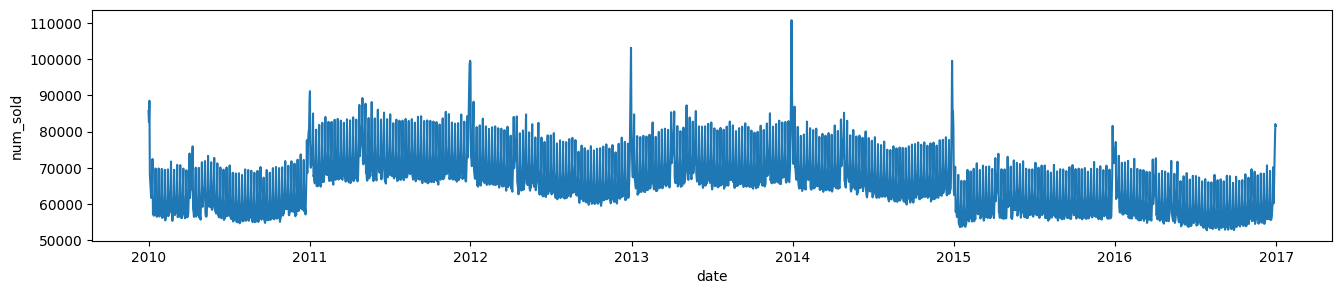

In [85]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby('date')[target].sum()
)
plt.show()

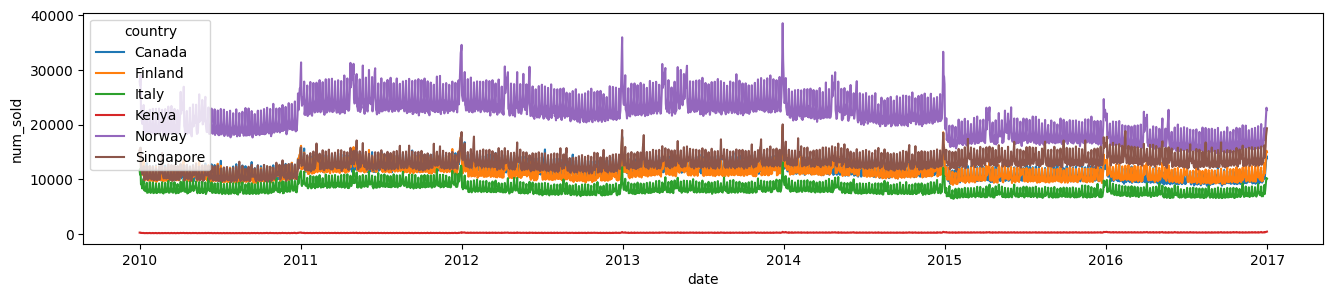

In [86]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'country'], as_index = False, observed=False)[target].sum(), 
    x = 'date', y = 'num_sold', hue = 'country'
)
plt.show()

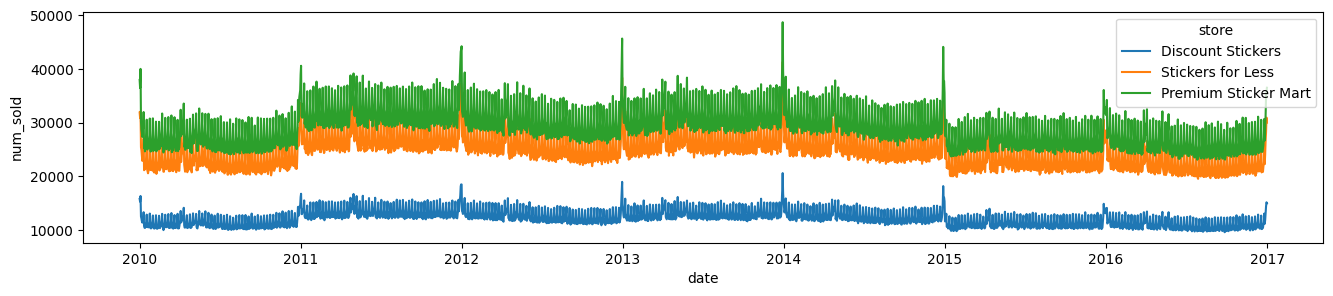

In [87]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'store'], as_index = False, observed=False)[target].sum(), 
    x = 'date', y = 'num_sold', hue = 'store'
)
plt.show()

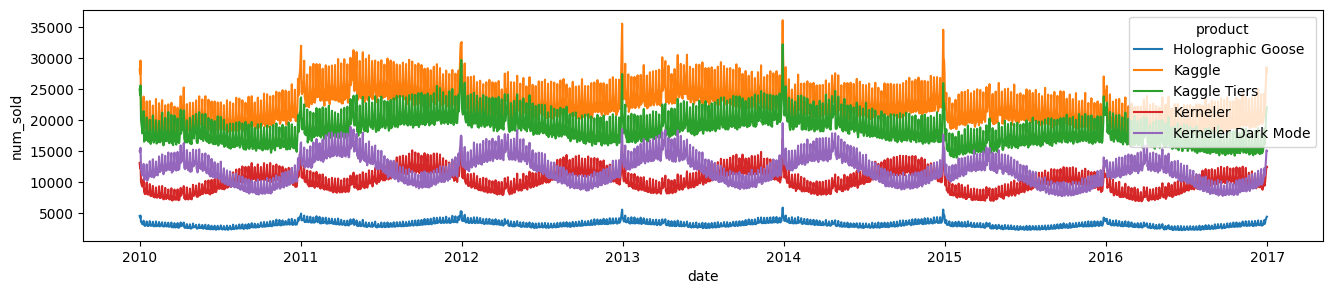

In [88]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'product'], as_index = False, observed=False)[target].sum(), 
    x = 'date', y = 'num_sold', hue = 'product'
)
plt.show()

# Reformulation Problem

In [145]:
df_re = df_train[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').join(
    s_est_daily_sum.rename('est_sum')
).assign(
    y_days = lambda x: x['date'].dt.dayofyear,
    est_y_mc = lambda x: x['est_sum'] - x.groupby('year')['est_sum'].transform(lambda x: x.clip(*x.quantile([0.025, 0.975])).mean()),
    est_yw_mc = lambda x: x['est_y_mc'] - x.groupby('weekday')['est_y_mc'].transform(lambda x: x.clip(*x.quantile([0.025, 0.975])).mean()),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_ywd_mc = lambda x: x['est_yw_mc'] - x.groupby(['md'], observed = True)['est_yw_mc'].transform('mean')
)

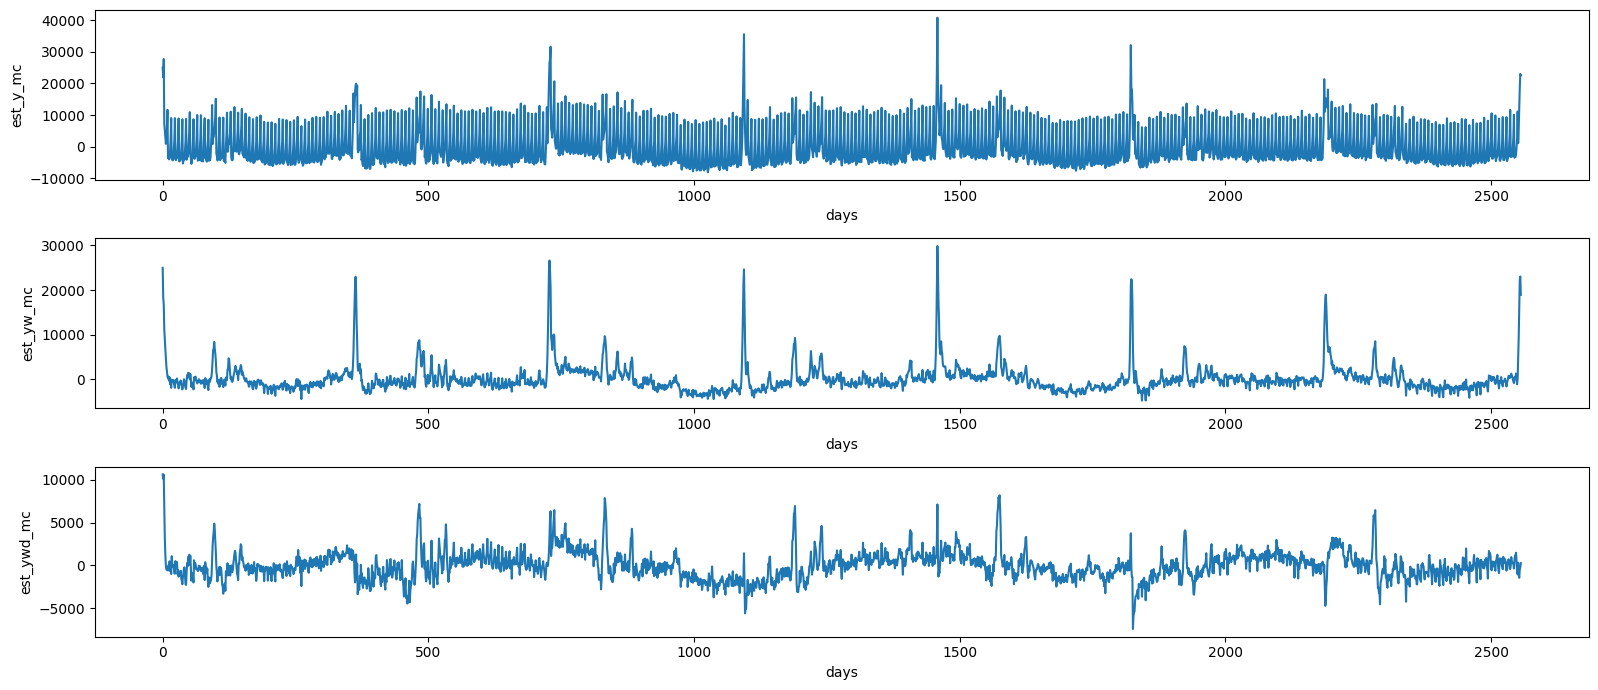

In [146]:
fig, axes = plt.subplots(3, 1, figsize = (16, 7))
sns.lineplot(df_re['est_y_mc'], ax = axes[0])
sns.lineplot(df_re['est_yw_mc'], ax = axes[1])
sns.lineplot(df_re['est_ywd_mc'], ax = axes[2])
plt.tight_layout()
plt.show()

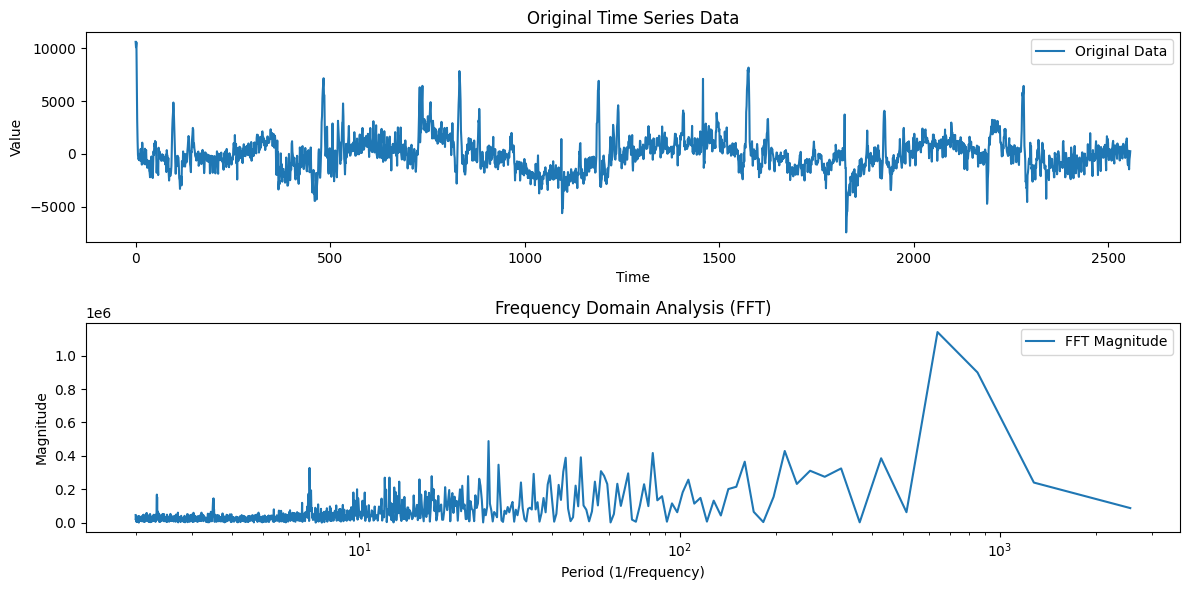

Top 3 periods with highest magnitude:
Period: 639.25, Magnitude: 1141143.18
Period: 852.33, Magnitude: 899259.43
Period: 25.32, Magnitude: 488160.77


In [147]:
def get_freq_mag(t, data):
    # FFT 수행
    fft_result = np.fft.fft(data)  # 복소수 결과 반환
    frequencies = np.fft.fftfreq(len(t), d=(t[1] - t[0]))  # 주파수 계산
    
    # 절대값(진폭) 계산
    magnitude = np.abs(fft_result)
    
    # 양의 주파수만 고려 (대칭 구조이므로)
    positive_frequencies = frequencies[frequencies > 0]
    positive_magnitude = magnitude[frequencies > 0]
    
    # 주기 계산
    periods = 1 / positive_frequencies
    return periods, positive_magnitude

periods, positive_magnitude = get_freq_mag(df_re.index.values, df_re['est_ywd_mc'].values)
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# 원 데이터
axes[0].plot(df_re.index.values, df_re['est_ywd_mc'].values, label="Original Data")
axes[0].set_title("Original Time Series Data")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].legend()

# 주파수 성분
axes[1].plot(periods, positive_magnitude, label="FFT Magnitude")
axes[1].set_title("Frequency Domain Analysis (FFT)")
axes[1].set_xlabel("Period (1/Frequency)")
axes[1].set_ylabel("Magnitude")
axes[1].set_xscale("log")
axes[1].legend()

plt.tight_layout()
plt.show()

# 주요 주기 출력
peak_indices = np.argsort(positive_magnitude)[-3:][::-1]  # 상위 3개 추출
print("Top 3 periods with highest magnitude:")
for idx in peak_indices:
    print(f"Period: {periods[idx]:.2f}, Magnitude: {positive_magnitude[idx]:.2f}")

In [148]:
df_re['c1'] = np.cos((df_re.index / 365.25) * np.pi)
df_re['s1'] = np.sin((df_re.index / 365.25) * np.pi)

In [149]:
from scipy.stats import pearsonr
(
    pearsonr(df_re['c1'], df_re['est_ywd_mc']),
    pearsonr(df_re['s1'], df_re['est_ywd_mc']),
    pearsonr(df_re.index, df_re['est_ywd_mc'])
)

(PearsonRResult(statistic=0.4057882897785389, pvalue=5.842997468115043e-102),
 PearsonRResult(statistic=-0.13398549482786237, pvalue=1.0275059548333903e-11),
 PearsonRResult(statistic=-0.015665849530754804, pvalue=0.4284580993125982))

In [150]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['month', 'md']),
    ('pt', 'passthrough', ['c1', 's1'])
])
reg_lr = make_pipeline(ct, LinearRegression())
reg_lr.fit(df_re[['c1', 's1', 'month', 'md']], df_re['est_ywd_mc'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['month', 'md']),
                                                 ('pt', 'passthrough',
                                                  ['c1', 's1'])])),
                ('linearregression', LinearRegression())])

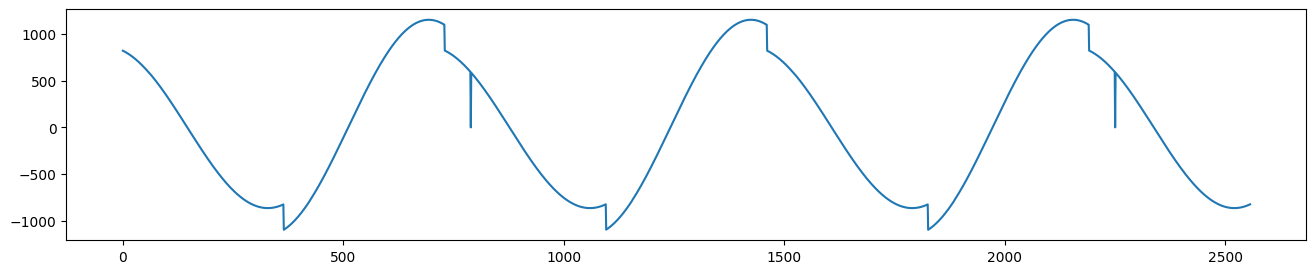

In [151]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(reg_lr.predict(df_re[['c1', 's1', 'month', 'md']]))
plt.show()

In [158]:
s_y = df_re.groupby('year')['est_sum'].mean()
s_y

year
2010    60903.472656
2011    71878.312500
2012    67695.234375
2013    70079.101562
2014    67514.375000
2015    60242.746094
2016    59101.410156
Name: est_sum, dtype: float32

In [153]:
s_weekday = df_re.groupby('weekday')['est_y_mc'].mean()
s_md = df_re.groupby('md')['est_yw_mc'].mean()

In [180]:
df_re = df_re.assign(
    est_y = s_y.mean(),
    est_w = lambda x: x['weekday'].map(s_weekday), 
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_md = lambda x: x['md'].map(s_md),
    est_days = lambda x: reg_lr.predict(x[['c1', 's1', 'month', 'md']]),
    est_sum_prd = lambda x: x['est_y'] + x['est_w'] + x['est_md'] + x['est_days']
)

In [ ]:
s_yt = pd.Series({2017: 60000, 2018: 60000, 2019: 72000})

In [184]:
df_re_test = df_test[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').assign(
    c1 = lambda x: np.cos((x.index / 365.25) * np.pi),
    s1 = lambda x: np.sin((x.index / 365.25) * np.pi),
    est_y = lambda x: x['year'].map(s_yt), 
    est_w = lambda x: x['weekday'].map(s_weekday), 
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_md = lambda x: x['md'].map(s_md),
    est_days = lambda x: reg_lr.predict(x[['c1', 's1', 'month', 'md']]),
    est_sum = lambda x: x['est_y'] + x['est_w'] + x['est_md'] + x['est_days']
)

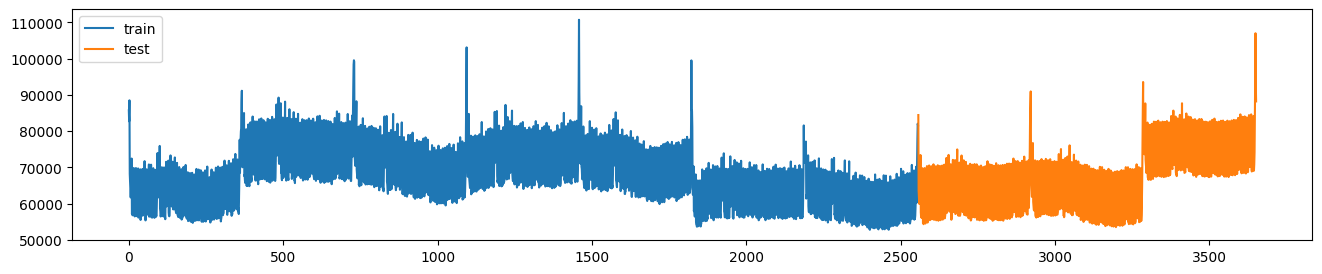

In [185]:
fig = plt.figure(figsize = (16, 3))
plt.plot(df_re.index, df_re['est_sum'], label='train')
plt.plot(df_re_test.index, df_re_test['est_sum'], label='test')
plt.legend()
plt.show()

In [56]:
df_ratio.apply(
    lambda x: pearsonr(x, x.index)
)

Canada                                                           \
  Discount Stickers                                                            
  Holographic Goose        Kaggle  Kaggle Tiers  Kerneler Kerneler Dark Mode   
0         -0.086955 -1.704920e-01 -2.098546e-01  0.031481      -1.778558e-01   
1          0.000011  3.935259e-18  7.674077e-27  0.111489       1.286298e-19   

                                                                              \
  Stickers for Less                                                            
  Holographic Goose        Kaggle  Kaggle Tiers  Kerneler Kerneler Dark Mode   
0         -0.090521 -1.824742e-01 -2.186701e-01  0.030046      -1.808473e-01   
1          0.000005  1.393758e-20  4.684514e-29  0.128783       3.069963e-20   

   ...         Singapore                                        \
   ... Stickers for Less                                         
   ... Holographic Goose    Kaggle Kaggle Tiers       Kerneler   
0  ...          0.667157  0.854744     0.814373   6.190611e-01   
1  ...          0.000000  0.000000     0.000000  1.917227e-270   

                                                                  \
                     Premium Sticker Mart                          
  Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers   
0       4.427907e-01             0.664159  0.851063     0.811893   
1      2.965007e-123             0.000000  0.000000     0.000000   

                                     
                                     
        Kerneler Kerneler Dark Mode  
0   6.157612e-01       4.422727e-01  
1  8.678419e-267      6.149169e-123  

[2 rows x 90 columns]

2557.0


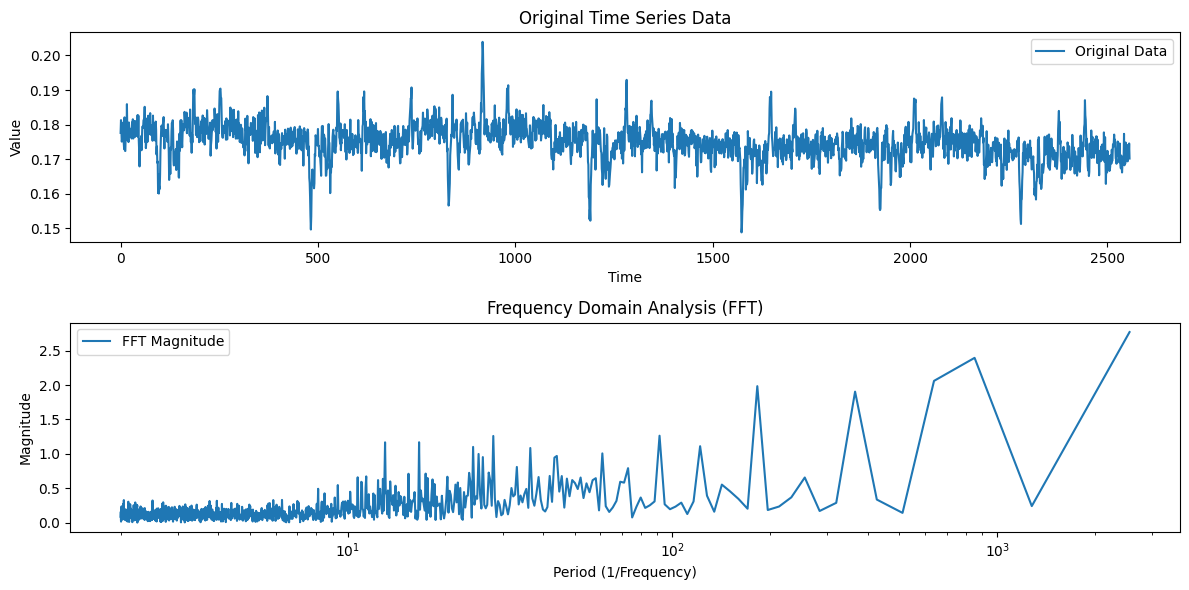

In [57]:
periods, positive_magnitude = get_freq_mag(df_ratio_country.index, df_ratio_country['Canada'])

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# 원 데이터
axes[0].plot(df_ratio_country.index, df_ratio_country['Canada'], label="Original Data")
axes[0].set_title("Original Time Series Data")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].legend()

# 주파수 성분
axes[1].plot(periods, positive_magnitude, label="FFT Magnitude")
axes[1].set_title("Frequency Domain Analysis (FFT)")
axes[1].set_xlabel("Period (1/Frequency)")
axes[1].set_ylabel("Magnitude")
axes[1].set_xscale("log")
axes[1].legend()

print(periods[np.argmax(positive_magnitude)])
plt.tight_layout()
plt.show()

In [58]:
df_ratio_country.apply(
    lambda x: get_freq_mag(x.index, x)
).apply(
    lambda x: [x[0][np.argmax(x[1])], np.max(x[1])]
    , axis = 0
)

country,Canada,Finland,Italy,Kenya,Norway,Singapore
0,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
1,2.769435,7.570643,8.638736,1.284605,33.977775,27.011528


In [59]:
df_ratio_store.apply(
    lambda x: get_freq_mag(x.index, x)
).apply(
    lambda x: [x[0][np.argmax(x[1])], np.max(x[1])]
    , axis = 0
)

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
0,2.743562,3.382275,7.083102
1,0.320516,0.530296,0.669903


In [60]:
df_ratio_product.apply(
    lambda x: get_freq_mag(x.index, x)
).apply(
    lambda x: [x[0][np.argmax(x[1])], np.max(x[1])]
    , axis = 0
)

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
0,365.285714,639.250000,639.250000,365.285714,365.285714
1,7.511217,12.074416,14.470344,35.995918,44.894159


In [61]:
df_ratio_country.apply(
    lambda x: pearsonr(x.index, x)
)

country,Canada,Finland,Italy,Kenya,Norway,Singapore
0,-3.496758e-01,2.426578e-01,-4.417765e-01,0.931743,-0.703849,0.887559
1,1.972048e-74,1.381518e-35,1.235365e-122,0.000000,0.000000,0.000000


In [62]:
df_ratio_store.apply(
    lambda x: pearsonr(x.index, x)
)

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
0,0.029725,0.012239,-0.029639
1,0.132916,0.536180,0.134047


In [63]:
df_ratio_product.apply(
    lambda x: pearsonr(x.index, x)
)

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
0,0.017067,0.062388,-0.033236,1.113067e-01,-1.043446e-01
1,0.388309,0.001598,0.092905,1.669032e-08,1.235058e-07


In [64]:
products = df_train['product'].unique()
df_dr = df_train.assign(
    ratio = lambda x: x['num_sold'] / x.groupby('days')['num_sold'].transform('sum'),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    logit = lambda x: np.log(x['ratio'] / (1 - x['ratio'])),
    c1 = lambda x: np.cos((x['days'] / 365.25 * 2) * np.pi),
    s1 = lambda x: np.sin((x['days'] / 365.25 * 2) * np.pi),
    c2 = lambda x: np.cos((x['days'] / 365.25) * np.pi),
    s2 = lambda x: np.sin((x['days'] / 365.25) * np.pi),
    y_days = lambda x: x['date'].dt.dayofyear,
).pipe(
    lambda x: pd.concat([x]
        + [(x['c1'] * (x['product'] == i)).rename('c1_{}'.format(i)) for i in products]
        + [(x['s1'] * (x['product'] == i)).rename('s1_{}'.format(i)) for i in products]
        + [(x['c2'] * (x['product'] == i)).rename('c2_{}'.format(i)) for i in products]
        + [(x['s2'] * (x['product'] == i)).rename('s2_{}'.format(i)) for i in products]
        + [(x['days'] * (x['country'] == i)).rename('d_{}'.format(i)) for i in df_train['country'].unique()]
    , axis=1)
)

In [166]:
X_cs = ['c1_{}'.format(i) for i in products] + \
    ['s1_{}'.format(i) for i in products] + \
    ['c2_{}'.format(i) for i in products] + \
    ['s2_{}'.format(i) for i in products]
X_d = ['d_{}'.format(i) for i in df_train['country'].unique()]

In [167]:
df_dr_train = df_dr.loc[df_dr['year'] < 2016]
df_dr_test = df_dr.loc[df_dr['year'] >= 2016]

df_dr_re = df_dr_train[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').join(
    s_est_daily_sum.rename('est_sum')
).assign(
    est_y_mc = lambda x: x['est_sum'] - x.groupby('year')['est_sum'].transform('mean'),
    est_yw_mc = lambda x: x['est_y_mc'] - x.groupby('weekday')['est_y_mc'].transform('mean'),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_ywd_mc = lambda x: x['est_yw_mc'] - x.groupby('md')['est_yw_mc'].transform('mean'),
    c1 = lambda x: np.cos((x.index / 365.25) * np.pi),
    s1 = lambda x: np.sin((x.index / 365.25) * np.pi),
)

s_weekday = df_dr_re.groupby('weekday')['est_y_mc'].mean()
s_md = df_dr_re.groupby('md')['est_yw_mc'].mean()
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['month']),
    ('pt', 'passthrough', ['c1', 's1'])
])
reg_lr_est = make_pipeline(ct, LinearRegression())
reg_lr_est.fit(df_dr_re[['c1', 's1', 'month', 'md']], df_dr_re['est_ywd_mc'])
df_dr_re_test = df_dr_test[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').join(
    s_est_daily_sum.rename('est_sum')
).assign(
    c1 = lambda x: np.cos((x.index / 365.25) * np.pi),
    s1 = lambda x: np.sin((x.index / 365.25) * np.pi),
    est_y = 60000, 
    est_w = lambda x: x['weekday'].map(s_weekday), 
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_md = lambda x: x['md'].map(s_md),
    est_days = lambda x: reg_lr_est.predict(x[['c1', 's1', 'month']]),
    est_sum_prd = lambda x: x['est_y'] + x['est_w'] + x['est_md'] + x['est_days']
)

df_dr_train = df_dr_train.join(df_dr_re['est_sum'], on = 'days')
df_dr_test = df_dr_test.join(df_dr_re_test[['est_sum', 'est_sum_prd']], on = 'days')

In [172]:
X_all = ['country', 'store', 'product', 'weekday', 'md', 'month', 'days'] + X_cs + X_d
def eval_model(model, fit_params = {}):
    model.fit(df_dr_train[X_all], df_dr_train['logit'], **fit_params)
    prd = model.predict(df_dr_test[X_all])
    prd_train = model.predict(df_dr_train[X_all])
    print(
        r2_score(df_dr_test['logit'], prd),
        r2_score(df_dr_train['logit'], prd_train),
        mean_absolute_percentage_error(
            df_dr_test['num_sold'], 1 / (1 + np.exp(-prd)) * df_dr_test['est_sum_prd']
        ),
        mean_absolute_percentage_error(
            df_dr_train['num_sold'], 1 / (1 + np.exp(-prd_train)) * df_dr_train['est_sum']
        )
    )
    return pd.Series(prd, index = df_dr_test.index)

In [176]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('mm', MinMaxScaler(), X_d + ['days']),
    ('pt', 'passthrough', X_cs)
])
reg_lr = make_pipeline(ct, LinearRegression())
lr_prd = eval_model(reg_lr).rename('lr')

0.997291567332591 0.9984230621541808 0.06873211209521528 0.052249227952818666


In [180]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d )
])
reg_lgb = make_pipeline(ct, lgb.LGBMRegressor(verbose = -1, num_leaves=7, n_estimators=3000, learning_rate=0.1))
lgb_prd = eval_model(reg_lgb).rename('lgb')

0.9981956465636619 0.9990363857698029 0.05393083792064929 0.04102927151615179


In [92]:
df_tmp = df_dr_test.join(
    ((1 / (1 + np.exp(-lgb_prd))) * df_dr_test['est_sum_prd']).rename('prd')
)

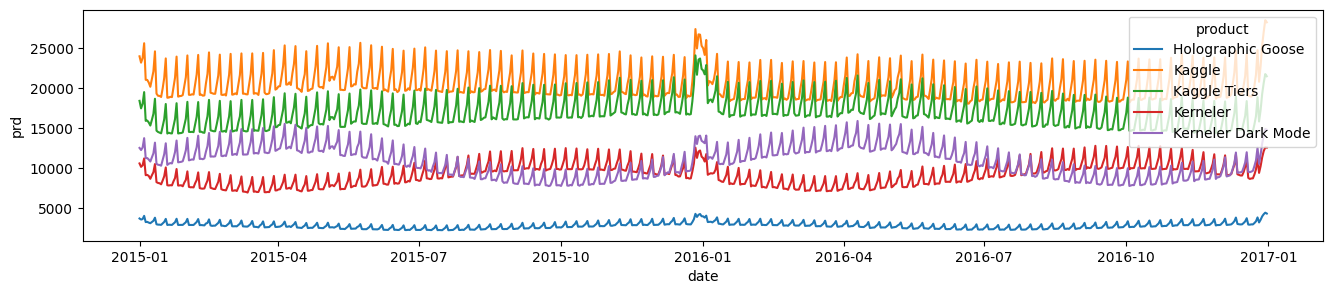

In [94]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_tmp.groupby(['date', 'product'], as_index = False, observed=False)['prd'].sum(), 
    x = 'date', y = 'prd', hue = 'product'
)
plt.show()

In [156]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d)
])
reg_lgb2 = make_pipeline(ct, lgb.LGBMRegressor(verbose = -1, num_leaves=15, n_estimators=3000, learning_rate=0.1))
lgb_prd2 = eval_model(reg_lgb2).rename('lgb2')

0.9925105530397123 0.9991424396600198 0.10460537619278408 0.03905514172976699


In [728]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d)
])
reg_xgb = make_pipeline(ct, xgb.XGBRegressor(max_depth=3, n_estimators=2500, learning_rate = 0.05))
xgb_prd = eval_model(reg_xgb).rename('xgb')

0.9931966450526981 0.9990344763180253 0.09982724456047286 0.04147908


In [155]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d)
])
reg_xgb2 = make_pipeline(ct, xgb.XGBRegressor(max_depth=2, n_estimators=2500, learning_rate = 0.05))
xgb_prd2 = eval_model(reg_xgb2).rename('xgb2')

0.9932071163858002 0.9989804179492618 0.09985675825801088 0.042518307


In [730]:
ct = ColumnTransformer([
    ('pt', 'passthrough', ['country', 'store', 'product', 'weekday', 'md', 'month', 'year'] +  X_cs + X_d),
]).set_output(transform='pandas')
reg_cb = make_pipeline(ct, cb.CatBoostRegressor(
    max_depth=7, n_estimators=3000, learning_rate = 0.05, verbose = 0, task_type = 'GPU',
    cat_features = ['pt__country', 'pt__store', 'pt__product', 'pt__weekday', 'pt__md', 'pt__month']
))
cb_prd = eval_model(reg_cb).rename('cb')

0.993185013472373 0.9990300299170465 0.09903968184276073 0.041574340244459794


In [731]:
ct = ColumnTransformer([
    ('pt', 'passthrough', ['country', 'store', 'product', 'weekday', 'md', 'month', 'year'] +  X_cs + X_d),
]).set_output(transform='pandas')
reg_cb2 = make_pipeline(ct, cb.CatBoostRegressor(
    max_depth=6, n_estimators=3000, learning_rate = 0.05, verbose = 0, task_type = 'GPU',
    cat_features = ['pt__country', 'pt__store', 'pt__product', 'pt__weekday', 'pt__md', 'pt__month']
))
cb_prd2 = eval_model(reg_cb2).rename('cb2')

0.9931147458953454 0.9990154235744044 0.09948836240442328 0.04187168621054571


In [732]:
df_vt = pd.concat([
    lr_prd, lgb_prd, lgb_prd2, xgb_prd, xgb_prd2, cb_prd, cb_prd2
], axis=1)

In [741]:
mean_absolute_percentage_error(
    df_dr_test['num_sold'],
    (1 / (1 + np.exp(-df_vt.dot([0.25, 0.1, 0.1, 0.1, 0.25, 0.1, 0.1])))) * df_dr_test['est_sum_prd']
)

0.09778611782219765

In [692]:
df_dr_t = df_test.assign(
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    c1 = lambda x: np.cos((x['days'] / 365.25 * 2) * np.pi),
    s1 = lambda x: np.sin((x['days'] / 365.25 * 2) * np.pi),
    c2 = lambda x: np.cos((x['days'] / 365.25) * np.pi),
    s2 = lambda x: np.sin((x['days'] / 365.25) * np.pi),
).pipe(
    lambda x: pd.concat([x]
        + [(x['c1'] * (x['product'] == i)).rename('c1_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['s1'] * (x['product'] == i)).rename('s1_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['c2'] * (x['product'] == i)).rename('c2_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['s2'] * (x['product'] == i)).rename('s2_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['days'] * (x['country'] == i)).rename('d_{}'.format(i)) for i in df_train['country'].unique()]
    , axis=1)
).join(
    df_re_test['est_sum'], on = 'days'
)

In [716]:
X_all = ['country', 'store', 'product', 'weekday', 'md', 'month', 'days'] + X_cs + X_d
for i in [reg_lr, reg_lgb, reg_lgb2, reg_xgb, reg_xgb2, reg_cb, reg_cb2]:
    i.fit(df_dr[X_all], df_dr['logit'])
    prd_train = i.predict(df_dr[X_all])
    print(
        mean_absolute_percentage_error(
            df_dr['num_sold'], 1 / (1 + np.exp(-prd_train)) * df_dr['days'].map(s_est_daily_sum)
        )
    )

0.05375023309653164


In [717]:
prds = list()
for name, i in zip(
    ['lr', 'lgb', 'lgb2', 'xgb', 'xgb2', 'cb', 'cb2'],
    [reg_lr, reg_lgb, reg_lgb2, reg_xgb, reg_xgb2, reg_cb, reg_cb2]
):
    prd = i.predict(df_dr_t[X_all])
    prds.append(
        pd.Series(1 / (1 + np.exp(-prd)) * df_dr_t['est_sum'], index = df_dr_t.index, name = name)
    )

In [714]:
pd.concat(prds, axis=1).dot([0.0, 0.2, 0.1, 0.1, 0.4, 0.1, 0.1]).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission1.csv')
)

In [715]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission1.csv -m "1"

100%|██████████████████████████████████████| 2.38M/2.38M [00:02<00:00, 1.03MB/s]
Successfully submitted to Forecasting Sticker Sales

In [719]:
pd.concat(prds, axis=1).dot([0.2, 0.1, 0.1, 0.1, 0.3, 0.1, 0.1]).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission2.csv')
)

In [720]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission2.csv -m "2"

100%|███████████████████████████████████████| 2.38M/2.38M [00:03<00:00, 787kB/s]
Successfully submitted to Forecasting Sticker Sales

In [721]:
pd.concat(prds, axis=1).dot([0.1, 0.15, 0.1, 0.1, 0.35, 0.1, 0.1]).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission3.csv')
)

In [722]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission3.csv -m "3"

100%|██████████████████████████████████████| 2.38M/2.38M [00:02<00:00, 1.00MB/s]
Successfully submitted to Forecasting Sticker Sales

# Reformulation Problem 2

In [84]:
products = df_train['product'].unique()
df_dr = df_train.assign(
    ratio = lambda x: x['num_sold'] / x.groupby('days')['num_sold'].transform('sum'),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
)

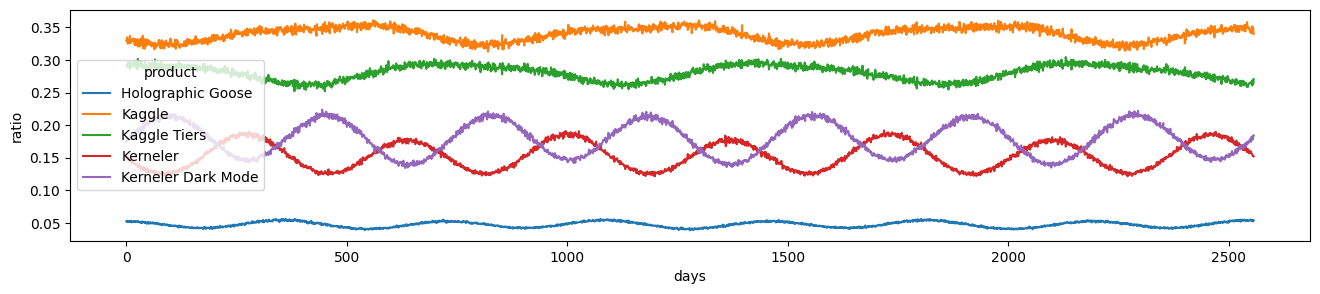

In [85]:
plt.figure(figsize = (16, 3))
sns.lineplot(
    df_dr.groupby(['days', 'product', 'weekday'], observed = True, as_index=False)['ratio'].sum(), 
    x = 'days', y = 'ratio', hue = 'product'
)
plt.show()

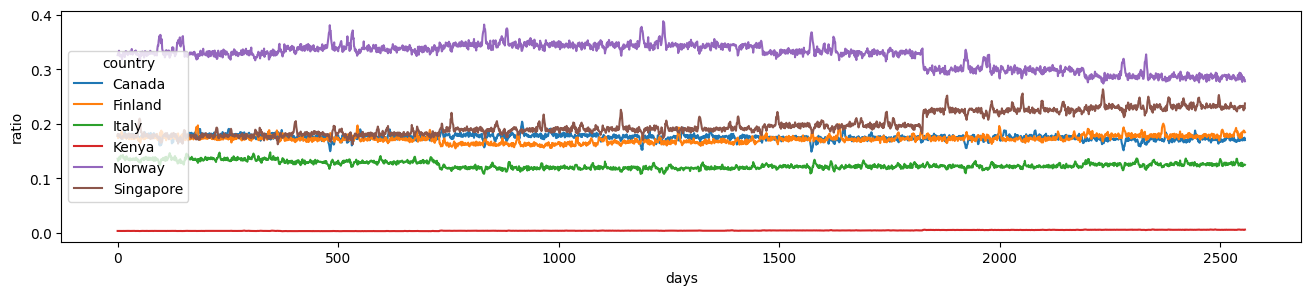

In [86]:
plt.figure(figsize = (16, 3))
sns.lineplot(
    df_dr.groupby(['days', 'country'], observed = True, as_index=False)['ratio'].sum(), 
    x = 'days', y = 'ratio', hue = 'country'
)
plt.show()

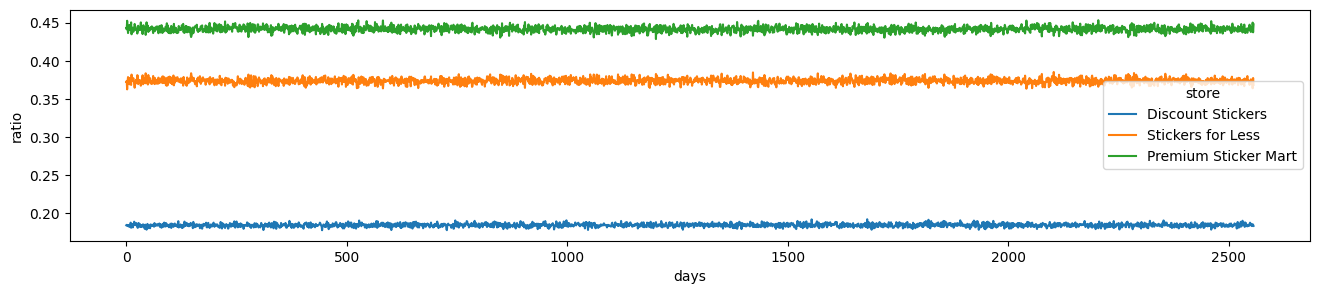

In [87]:
plt.figure(figsize = (16, 3))
sns.lineplot(
    df_dr.groupby(['days', 'store'], observed = True, as_index=False)['ratio'].sum(), 
    x = 'days', y = 'ratio', hue = 'store'
)
plt.show()

In [88]:
df_dr.groupby(['days', 'store'], observed = True, as_index=False)['ratio'].sum().groupby('store', observed=True)['ratio'].mean()

store
Discount Stickers       0.184717
Stickers for Less       0.373718
Premium Sticker Mart    0.441565
Name: ratio, dtype: float32

In [89]:
df_tmp = df_dr.loc[
    df_dr['md'] != '02-29'
]
df_dr_train = df_tmp.loc[df_tmp['year'] < 2014]
df_dr_test = df_tmp.loc[df_tmp['year'] >= 2014]

In [90]:
df_dr_train.groupby(['days', 'product'], observed = True, as_index=False)['ratio'].sum()

,days,product,ratio
0,0,Holographic Goose,0.052477
1,0,Kaggle,0.329293
2,0,Kaggle Tiers,0.291154
3,0,Kerneler,0.152367
4,0,Kerneler Dark Mode,0.174709
...,...,...,...
7295,1460,Holographic Goose,0.053317
7296,1460,Kaggle,0.327939
7297,1460,Kaggle Tiers,0.292037
7298,1460,Kerneler,0.148860


In [91]:
r2_score(
    df_dr_test.groupby(['days', 'product', 'store'], observed = True)['ratio'].sum(),
    df_dr_train.groupby(['days', 'product', 'store'], observed = True)['ratio'].sum().iloc[:16425]
)

0.9965367317199707

In [92]:
r2_score(
    df_dr_test.groupby(['days', 'country'], observed = True)['ratio'].sum(),
    df_dr_train.groupby(['days', 'country'], observed = True)['ratio'].sum().iloc[:6570]
)

0.9330101013183594

In [207]:
df_yc_ratio = df_dr.groupby(['year', 'days', 'country'], observed = True, as_index=False)['ratio'].sum().groupby(['year', 'country'], observed = True)['ratio'].mean().unstack()
df_yc_ratio

country,Canada,Finland,Italy,Kenya,Norway,Singapore
year,,,,,,
2010,0.177861,0.175360,0.135374,0.003492,0.329870,0.178043
2011,0.174793,0.172524,0.129603,0.003191,0.338421,0.181467
2012,0.178468,0.163207,0.119169,0.003791,0.345595,0.189770
2013,0.174775,0.167459,0.118725,0.003967,0.344276,0.190798
2014,0.172855,0.172815,0.121636,0.004412,0.331377,0.196906
2015,0.174597,0.173259,0.121945,0.005294,0.299932,0.224972
2016,0.170968,0.178944,0.125900,0.005647,0.286931,0.231609


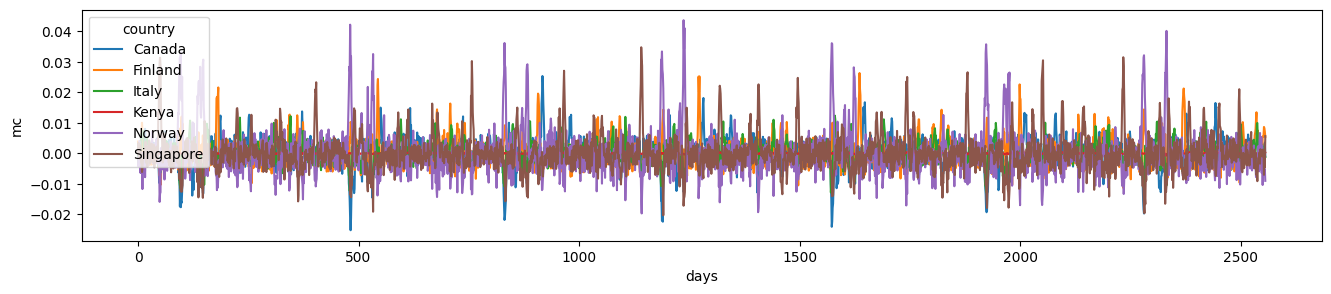

In [94]:
plt.figure(figsize=(16, 3))
df_mc_country = df_tmp.groupby(['year', 'days', 'country', 'weekday'], observed = True, as_index=False)['ratio'].sum().pipe(
    lambda x: x.assign(mc = lambda x: x['ratio'] - x.groupby(['year', 'country'], observed = True)['ratio'].transform('mean'))
)
sns.lineplot(df_mc_country, x = 'days', y = 'mc', hue = 'country')

plt.show()

In [95]:
df_dr_train = df_mc_country.loc[df_mc_country['year'] < 2014]
df_dr_test = df_mc_country.loc[df_mc_country['year'] >= 2014]

In [96]:
r2_score(
    df_dr_test.groupby(['days', 'country'], observed = True)['mc'].sum(),
    df_dr_train.groupby(['days', 'country'], observed = True)['mc'].sum().iloc[:6570]
)

-0.6130486726760864

In [97]:
df_dr_train.groupby(['days', 'country'], observed = True, as_index = False)['mc'].sum().groupby('country', observed=False).apply(
    lambda x: pearsonr(x['days'], x['mc']), include_groups = False
)

country
Canada       (0.018780140191908132, 0.47335141038233314)
Finland       (0.015146363386930036, 0.5630756287517331)
Italy         (0.02174981271320936, 0.40628689075982344)
Kenya         (0.03999965470142861, 0.12659027417669116)
Norway       (-0.03359265045129467, 0.19954952554953428)
Singapore    (0.0033458069671626566, 0.8983595105773184)
dtype: object

In [99]:
from scipy.stats import f_oneway
df_dr_train.groupby(['days', 'country', 'weekday'], observed = True, as_index = False)['mc'].sum().groupby('country', observed=True).apply(
    lambda x: f_oneway(*x.groupby('weekday')['mc'].agg(list)), include_groups = False
)

country
Canada        (0.3616166950866813, 0.9033125670120248)
Finland       (0.5566626488880121, 0.7650246941728768)
Italy         (0.3260904111022657, 0.9235280470725384)
Kenya         (0.6842825552372763, 0.6623957218121488)
Norway         (0.915657599997259, 0.4825297475718826)
Singapore    (0.20693144399865246, 0.9747197044120052)
dtype: object

In [109]:
df_dr['y_2'] = df_dr['year'] % 2

In [126]:
s_ratio = df_dr.groupby(['y_2', 'md', 'country', 'product', 'store'], observed = False)['ratio'].mean()
s_ratio

y_2  md     country    product             store               
0    01-01  Canada     Holographic Goose   Discount Stickers       0.001653
                                           Stickers for Less       0.003376
                                           Premium Sticker Mart    0.004160
                       Kaggle              Discount Stickers       0.010736
                                           Stickers for Less       0.020710
                                                                     ...   
1    12-31  Singapore  Kerneler            Stickers for Less       0.010754
                                           Premium Sticker Mart    0.012788
                       Kerneler Dark Mode  Discount Stickers       0.006082
                                           Stickers for Less       0.012769
                                           Premium Sticker Mart    0.015286
Name: ratio, Length: 65880, dtype: float32

In [164]:
df_dr_est = df_dr[['days', 'y_2', 'md', 'country', 'product', 'store', 'ratio', 'num_sold']].join(
    s_ratio.rename('est_ratio'), on = ['y_2', 'md', 'country', 'product', 'store']
).join(
    df_re['est_sum_prd'].rename('est_sum'), on = 'days'
)
df_dr_est

,days,y_2,md,country,product,store,ratio,num_sold,est_ratio,est_sum
id,,,,,,,,,,
0,0,0,01-01,Canada,Holographic Goose,Discount Stickers,0.001694,145.205307,0.001653,80709.595953
1,0,0,01-01,Canada,Kaggle,Discount Stickers,0.011352,973.000000,0.010736,80709.595953
2,0,0,01-01,Canada,Kaggle Tiers,Discount Stickers,0.010570,906.000000,0.009469,80709.595953
3,0,0,01-01,Canada,Kerneler,Discount Stickers,0.004935,423.000000,0.004664,80709.595953
4,0,0,01-01,Canada,Kerneler Dark Mode,Discount Stickers,0.005728,491.000000,0.005668,80709.595953
...,...,...,...,...,...,...,...,...,...,...
230125,2556,0,12-31,Singapore,Holographic Goose,Premium Sticker Mart,0.005713,466.000000,0.004640,86995.304430
230126,2556,0,12-31,Singapore,Kaggle,Premium Sticker Mart,0.035637,2907.000000,0.027733,86995.304430
230127,2556,0,12-31,Singapore,Kaggle Tiers,Premium Sticker Mart,0.028184,2299.000000,0.022882,86995.304430


In [165]:
r2_score(
    df_dr_est['ratio'], df_dr_est['est_ratio']
)

0.9873577952384949

In [166]:
mean_absolute_percentage_error(
    df_dr_est['num_sold'],  df_dr_est['est_ratio'] * df_dr_est['est_sum']
)

0.09209488874033674

In [175]:
df_dr_t = df_test.assign(
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    y_2 = lambda x: x['year'] % 2
)

In [179]:
df_dr_t[['days', 'y_2', 'md', 'country', 'product', 'store']].join(
    s_ratio.rename('est_ratio'), on = ['y_2', 'md', 'country', 'product', 'store']
).join(
    df_re_test['est_sum'], on = 'days'
).assign(
    num_sold = lambda x: x['est_ratio'] * x['est_sum']
)[['num_sold']].to_csv(os.path.join('result', 'submission4.csv'))

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission4.csv -m "4"

In [258]:
s_ratio = df_dr.groupby(['y_2', 'md', 'store', 'product', 'country'], observed = False)['ratio'].mean().groupby(['y_2', 'md', 'store', 'product'], observed = False).sum()
s_ratio = pd.DataFrame(
    0, index = pd.MultiIndex.from_product(
        df_dr[['y_2', 'md', 'store', 'product']].apply(lambda x: x.unique()).tolist() + [df_dr['country'].unique().tolist()]
    ), columns = ['ratio']
).assign(
    ratio = lambda x: x.index.map(lambda x: s_ratio.loc[x[:4]] * df_yc_ratio.iloc[-1].loc[x[4]])
).dropna()['ratio']

0  01-01  Discount Stickers     Holographic Goose   Canada       0.001669
                                                    Finland      0.001747
                                                    Italy        0.001229
                                                    Kenya        0.000055
                                                    Norway       0.002802
                                                                   ...   
1  02-29  Premium Sticker Mart  Kerneler Dark Mode  Finland      0.000000
                                                    Italy        0.000000
                                                    Kenya        0.000000
                                                    Norway       0.000000
                                                    Singapore    0.000000
Name: ratio, Length: 65880, dtype: float32

In [259]:
df_dr_t[['days', 'y_2', 'md', 'country', 'product', 'store']].join(
    s_ratio.rename('est_ratio'), on = ['y_2', 'md', 'store', 'product', 'country']
).join(
    df_re_test['est_sum'], on = 'days'
).assign(
    num_sold = lambda x: x['est_ratio'] * x['est_sum']
)[['num_sold']].to_csv(os.path.join('result', 'submission5.csv'))

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission5.csv -m "5"

# Reformulation Problem 3

In [135]:
df_train['ratio'] = df_train['num_sold'] / df_train.groupby('days')['num_sold'].transform('sum')

In [136]:
df_train

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md,ratio
id,,,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,145.205307,2010,1,1,5,0,3,0,01-01,0.001694
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000,2010,1,1,5,0,3,0,01-01,0.011352
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000,2010,1,1,5,0,3,0,01-01,0.010570
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000,2010,1,1,5,0,3,0,01-01,0.004935
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000,2010,1,1,5,0,3,0,01-01,0.005728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.000000,2016,12,31,6,2556,1,0,12-31,0.005713
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.000000,2016,12,31,6,2556,1,0,12-31,0.035637
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.000000,2016,12,31,6,2556,1,0,12-31,0.028184


In [143]:
df_sp_ratio = df_train.groupby(['year', 'y_2', 'md', 'store', 'product'], observed = True, as_index = False)['ratio'].sum()\
    .groupby(['y_2', 'md', 'store', 'product'], observed = True)['ratio'].mean().rename('sp_ratio')

In [151]:
df_train.assign(
    num_sold_c = lambda x: x.groupby(['days', 'country'], observed = True)['num_sold'].transform('sum'),
    num_sold_est = lambda x: x['num_sold_c'] * x['sp_ratio']
).pipe(
    lambda x: (
        mean_absolute_percentage_error(x['num_sold'], x['num_sold_est']),
        r2_score(x['num_sold'], x['num_sold_est'])
    )
)

(0.038968872, 0.99575874802953)

In [147]:
df_train = df_train.join(df_sp_ratio, on = ['y_2', 'md', 'store', 'product'])
df_test = df_test.join(df_sp_ratio, on = ['y_2', 'md', 'store', 'product'])

In [155]:
df_train_c = df_train.groupby(
    ['date', 'country', 'year', 'month', 'day', 'weekday', 'days', 'y_8', 'y_2', 'md'], observed = True, as_index=False
)['num_sold'].sum()
df_train_c.head()

,date,country,year,month,day,weekday,days,y_8,y_2,md,num_sold
0,2010-01-01,Canada,2010,1,1,5,0,3,0,01-01,15244.205078
1,2010-01-01,Finland,2010,1,1,5,0,3,0,01-01,15360.000000
2,2010-01-01,Italy,2010,1,1,5,0,3,0,01-01,11645.000000
3,2010-01-01,Kenya,2010,1,1,5,0,3,0,01-01,295.828796
4,2010-01-01,Norway,2010,1,1,5,0,3,0,01-01,27923.000000


In [157]:
df_train.to_parquet(os.path.join('data', 'train.parquet'))
df_test.to_parquet(os.path.join('data', 'test.parquet'))
df_train_c.to_parquet(os.path.join('data', 'train_c.parquet'))